In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


%matplotlib inline

# Data Files Structure

```
./data
├── eval
│   └── sample_submission.csv
└── train
    ├── Ml_item2attributes.json
    ├── directors.tsv
    ├── genres.tsv
    ├── titles.tsv
    ├── train_ratings.csv
    ├── writers.tsv
    └── years.tsv
```

In [2]:
data_path = './data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv'))

## Train Data

- 유저 31360 명

- 영화 6807 개

- Data sparsity ratio:  0.9758536052697853

- 굉장히 dense함 -> user들이 본 영화가 대부분 겹친다는 뜻

In [3]:
print(train_df.info())
print(train_df.head(5))
print("users", train_df['user'].nunique())
print("items", train_df['item'].nunique())
print("Data sparsity ratio: ", 1 - len(train_df) / (train_df['user'].nunique() * train_df['item'].nunique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB
None
   user  item        time
0    11  4643  1230782529
1    11   170  1230782534
2    11   531  1230782539
3    11   616  1230782542
4    11  2140  1230782563
users 31360
items 6807
Data sparsity ratio:  0.9758536052697853


# Side Information

|정보|개수|비고|
|:------:|:-----:|:-----:|
|year|6799|**1922 ~ 2014 년**|
|writer|11306|**2989 명**|
|title|6807|**-**|
|genre|15933|**18 개**|
|director|5905|**1340 명**|

In [114]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

### Year

- dtype : int64

- len : 5152639

- unique : 93

- 아래 영화의 year 정보 없음 (8 개)

    - 6987,   3310,   7243,   8511,  32898,   7065, 119145,   6988

In [5]:
print(f'Data type:\n{year_data.dtypes}\n')
print(f"Length of years:\n{len(year_data)}\n")
print(f"Number of unique years:\n{year_data['year'].nunique()}\n")
print(f"List of missing info:\n{train_df.loc[~train_df['item'].isin(year_data['item'])]['item'].unique()}")

Data type:
item    int64
year    int64
dtype: object

Length of years:
6799

Number of unique years:
93

List of missing info:
[  6987   3310   7243   8511  32898   7065 119145   6988]


In [6]:
year_missing_data = train_df.loc[~train_df['item'].isin(year_data['item'])]['item'].unique()
missing_movies = title_data.loc[title_data['item'].isin(year_missing_data)]
missing_movies

,item,title
984,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ..."
1284,3310,"Kid, The (1921)"
2359,7065,"Birth of a Nation, The (1915)"
2620,7243,Intolerance: Love's Struggle Throughout the Ag...
2669,8511,"Immigrant, The (1917)"
2676,6988,Broken Blossoms or The Yellow Man and the Girl...
3177,32898,"Trip to the Moon, A (Voyage dans la lune, Le) ..."
6043,119145,Kingsman: The Secret Service (2015)


In [115]:
Columns = ['item', 'year']
year_insert_df = pd.DataFrame(columns=Columns)
for i, (item, string) in enumerate(zip(missing_movies['item'], missing_movies['title'])):
    year = int(string[re.search(r"\(\d{4}\)$", string).start()+1:-1])
    year_insert_df.loc[i] = [item, year]
year_data = pd.concat([year_data, year_insert_df], ignore_index=True)

In [116]:
print(f'Data type:\n{year_data.dtypes}\n')
print(f"Length of years:\n{len(year_data)}\n")
print(f"Number of unique years:\n{year_data['year'].nunique()}\n")
print(f"List of missing info:\n{train_df.loc[~train_df['item'].isin(year_data['item'])]['item'].unique()}")

Data type:
item    int64
year    int64
dtype: object

Length of years:
6807

Number of unique years:
101

List of missing info:
[]


### Writer

- dtype :  object

- len : 11306

- unique : 2989

- 1159 개의 영화에 대한 wirter 정보가 없음.

    - dtype: 'object'

In [9]:
print(f'Data type:\n{writer_data.dtypes}\n')
print(f"Length of writers:\n{len(writer_data)}\n")
print(f"Number of unique writers:\n{writer_data['writer'].nunique()}\n")
print(f"Number of missing info:\n{len(train_df.loc[~train_df['item'].isin(writer_data['item'])]['item'].unique())}")

Data type:
item       int64
writer    object
dtype: object

Length of writers:
11306

Number of unique writers:
2989

Number of missing info:
1159


### Title

- dtype :  object

- len : 6807

- unique : 6806

- War of the Worlds (2005) -> id 34048, 64997 중복으로 되어있음.

- 모든 영화에 대한 정보는 있음.

In [10]:
print(f'Data type:\n{title_data.dtypes}\n')
print(f"Length of titles:\n{len(title_data)}\n")
print(f"Number of unique titles:\n{title_data['title'].nunique()}\n")
print(f"Number of missing info:\n{len(train_df.loc[~train_df['item'].isin(title_data['item'])]['item'].unique())}")

Data type:
item      int64
title    object
dtype: object

Length of titles:
6807

Number of unique titles:
6806

Number of missing info:
0


중복된 영화 이름

In [11]:
title_data.loc[title_data.duplicated(subset='title', keep=False)]

,item,title
349,34048,War of the Worlds (2005)
1926,64997,War of the Worlds (2005)


중복된 영화에 점수를 매긴 유저 3200명

In [12]:
title_duplicated_df = train_df.loc[(train_df['item'] == 34048) | (train_df['item'] == 64997)]
print(title_duplicated_df)
print(f"\nNumber of users voting both: {title_duplicated_df['user'].nunique()}")

           user   item        time
126          11  34048  1230788489
349          11  64997  1251170446
5630        208  34048  1157583328
7675        258  34048  1221520795
11320       367  34048  1120865002
...         ...    ...         ...
5150174  138404  34048  1138010617
5150984  138414  34048  1386706180
5152924  138456  34048  1183783639
5153574  138472  34048  1194041076
5154459  138493  34048  1258390758

[3200 rows x 3 columns]

Number of users voting both: 3087


### Genre

- dtype :  object

- len : 15933

- unique : 18

- 모든 영화에 대한 정보 있음.

- 한 영화는 여러개의 장르를 가질 수 있음.

In [13]:
print(f'Data type:\n{genre_data.dtypes}\n')
print(f"Length of genres:\n{len(genre_data)}\n")
print(f"Number of unique genres:\n{genre_data['genre'].nunique()}\n")
print(f"Number of missing info:\n{len(train_df.loc[~train_df['item'].isin(genre_data['item'])]['item'].unique())}")

Data type:
item      int64
genre    object
dtype: object

Length of genres:
15933

Number of unique genres:
18

Number of missing info:
0


In [14]:
genre_df = pd.merge(train_df, genre_data, on=['item'])
genre_df.loc[(genre_df['item'] == 593) & (genre_df['user'] == 41244)] # sample

,user,item,time,genre
2742694,41244,593,1196995689,Crime
2742695,41244,593,1196995689,Horror
2742696,41244,593,1196995689,Thriller


### Director

- dtype :  object

- len : 5905

- unique : 1340

- 1304 개의 영화에 대해 감독 정보 없음.

- 감독은 다작 가능.

In [15]:
print(f'Data type:\n{director_data.dtypes}\n')
print(f"Length of directors:\n{len(director_data)}\n")
print(f"Number of unique directors:\n{director_data['director'].nunique()}\n")
print(f"Number of missing info:\n{len(train_df.loc[~train_df['item'].isin(director_data['item'])]['item'].unique())}")

Data type:
item         int64
director    object
dtype: object

Length of directors:
5905

Number of unique directors:
1340

Number of missing info:
1304


In [16]:
director_data.head(5)

,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005


# 시각화

## 가장 많은 장르

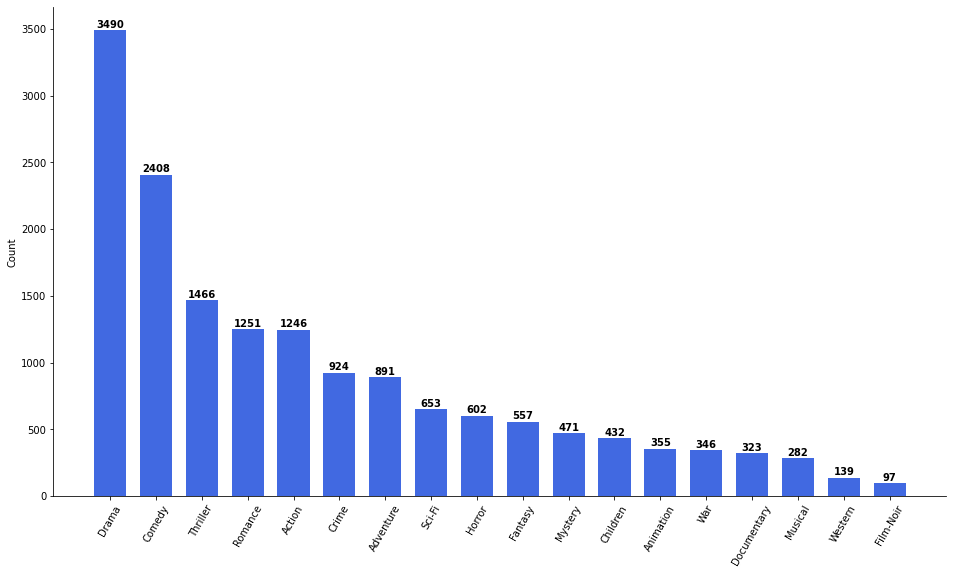

In [56]:
genres = genre_data['genre'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.bar(genres.index, genres,
width=0.7,
linewidth=2,
color='royalblue',
zorder=10
)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

for idx, value in zip(genres.index, genres):
    ax.text(idx, value+20, s=value,
            ha='center', 
            fontweight='bold'
            )

plt.xticks(rotation=60)
plt.ylabel('Count')
plt.show()

## 년도별 개봉된 영화 수

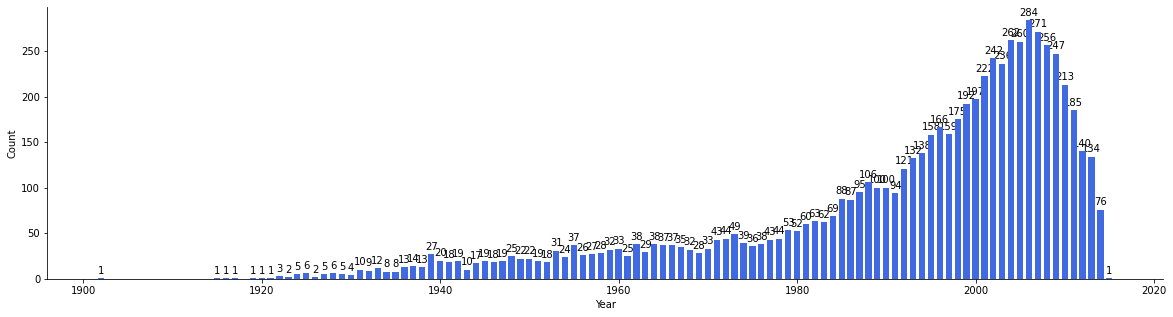

In [151]:
years = year_data['year'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.bar(years.index, years,
width=0.7,
linewidth=2,
color='royalblue',
zorder=10
)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

for idx, value in zip(years.index, years):
    ax.text(idx, value+5, s=value,
            ha='center', 
            # fontweight='bold'
            )

plt.xlabel('Year')
plt.ylabel('Count')
plt.show()